## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [2]:
test_num = 1

b_modes = 1
t_modes = 1
fwt_modes = 1
# lets go for B2T2 (so 5 DoF)
p = mf.ModelParameters.DynamicModel(b_modes + t_modes + fwt_modes)

## Create some global parameters
p.c = mf.ModelSymbol(value = 1.8,string = 'c') # chord of wing
p.s_t = mf.ModelSymbol(value = 12,string = 's_t') # total semi-span of wing
p.rho_t = mf.ModelSymbol(value = 19.53,string = 'rho_t') # per per unit area (kg/m^2)
p.ratio_fwt = mf.ModelSymbol(value = 0.2,string = 'sigma') # percentage of wing that is a FWT


# Respective spans
p.s_0 =  p.s_t*(1-p.ratio_fwt) # span of inner wing
p.s_1 =  p.s_t*p.ratio_fwt # span of inner wing

# Inner Wing stiffness Properties
p.EI = mf.ModelSymbol(value = 9.77e6,string = 'EI') # Bending stiffness for the wing
p.GJ = mf.ModelSymbol(value = 0.99e6,string = 'GJ') # Torsional Stiffness for the wing

# Location of flexural axes
p.e_0 = mf.ModelSymbol(value = 0.08,string = 'e_0')
p.x_f0 = sym.Rational(1,4)*p.c + p.e_0*p.c
p.e_1 = mf.ModelSymbol(value = 0,string = 'e_1') # e for the FWT
p.x_f1 = sym.Rational(1,4)*p.c + p.e_1*p.c

# FWT Properties
p.m_factor = mf.ModelSymbol(value = 1, string = 'delta_m')
p.m_1 = p.rho_t*p.c*p.s_t*p.ratio_fwt*p.m_factor

p.I_xx_1 = sym.Rational(1,12)*p.m_1*p.s_1**2 # inertia of FWT (uniform bar)
p.Lambda = mf.ModelSymbol(value = np.deg2rad(10),string = 'Lambda') # Flare Angle
p.Delta_m = mf.ModelSymbol(value = 0,string = 'Delta_m') # additional mass to apply at the FWT CoM

# Symbols to translate along inner wing and FWT
p.y_0 = sym.Symbol('y_0') # inner wing y chord
p.x_0 = sym.Symbol('x_0') # inner wing x chord
p.y_1 = sym.Symbol('y_1') # FWT y chord
p.x_1 = sym.Symbol('x_1') # FWT x chord

## Aero Parameters
p.rho = mf.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = mf.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = mf.ModelSymbol(value = -1.2,string = 'M_thetadot')    # Unsteady Torsional Term 

## Main Wing Specific
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0')               # C_L slope of main wing

## FWT Specific
p.a_1 = p.a_0 - p.a_0/p.s_1*p.y_1                                    # C_L slope of FWT
p.alpha_1 = mf.ModelSymbol(value = 0,string = 'alpha_1')             # FWT alpha
p.alphadot_1 = mf.ModelSymbol(value = 0,string = 'alphadot_1')       # FWT alphadot

## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point

# Factor to change the size of joint values
p.eta = mf.ModelMatrix(value = [1]*(b_modes+t_modes+fwt_modes),symbols=sym.symbols(f'eta:{p.qs}'))

In [3]:
#get shape functions for main wing
z_0,tau_0 = mf.ShapeFunctions_BN_TM(b_modes,t_modes,p.q[:-1],p.y_0,p.x_0,p.x_f0,0,factor=p.eta)

#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().R_y(p.alpha_r)
wing_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame = wing_frame.subs({p.x_0:p.x_f0})

fwt_root_frame = wing_frame.subs({p.y_0:p.s_0,p.x_0:p.x_f0}).Translate(-p.x_f0,0,0).R_x(-p.q[-1])
fwt_flexural_frame = fwt_root_frame.Translate(p.x_f1,p.y_1,0)
fwt_com_frame = fwt_root_frame.Translate(p.c/2,p.s_1/2,0)

#### Create Transforms

In [4]:
#Create Elemnts
M_wing = ele.MassMatrix(p.rho_t)
M_fwt = ele.MassMatrix(p.m_1,I_xx = p.I_xx_1)

inner_wing_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s_0,p.x_f0,p.EI,p.GJ,gravityPot=True)
fwt_ele = ele.RigidElement(fwt_com_frame,M_fwt,True)

# Create AeroForces
wing_AeroForces = ef.AeroForce_1.PerUnitSpan(p,wing_flexural_frame,p.a_0,
                               alphadot = tau_0 if isinstance(tau_0,int) else tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               rootAlpha = p.alpha_r,
                               deltaAlpha = tau_0,
                               alpha_zero = 0).integrate((p.y_0,0,p.s_0))


tau_s0 = tau_0.subs(p.y_0,p.s_0)
alpha_fwt =  p.alpha_1
alphadot_fwt = p.alphadot_1

# include wing twist in AoA
#alpha_fwt += tau_s0
#alphadot_fwt += tau_s0.diff(me.dynamicsymbols._t)


fwt_AeroForces_perUnit = ef.AeroForce_1.PerUnitSpan(p,fwt_flexural_frame,p.a_1,
                               alphadot = alphadot_fwt,
                               M_thetadot = p.M_thetadot,
                               e = p.e_1,
                               rootAlpha = alpha_fwt,
                                deltaAlpha = 0, 
                               alpha_zero = 0)
forces = []
segments = 5
for i in range(segments):
    seg_width = p.s_1/segments
    yi = seg_width/2 + i*seg_width
    forces.append(fwt_AeroForces_perUnit.subs({p.y_1:yi})*seg_width)
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
fwt_AeroForces = ef.ExternalForce(Q)


# Setup AoA of FWT
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda,p.q[-1])

# Add wing bend
#wing_bend = sym.atan(z_0.diff(p.y_0).subs({p.x_0:p.x_f0,p.y_0:p.s_0}))
#fwt_aoa = fwt_aoa.subs(p.q[-1],p.q[-1]-wing_bend)

## Sub in Aero Forces
fwt_AeroForces = fwt_AeroForces.subs({p.alpha_1:fwt_aoa,p.alphadot_1:fwt_aoa.diff(time)})

#Create Composite force
CompositeForce = ef.CompositeForce([wing_AeroForces,fwt_AeroForces])
# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele,fwt_ele],CompositeForce)

In [5]:
sm.to_pickle('test.pkl')
sm2 = mf.SymbolicModel.from_pickle('test.pkl')

PicklingError: Can't pickle q2: attribute lookup q2 on __main__ failed

In [ ]:
sm.to_file('test.py')
sm3 = mf.SymbolicModel.from_file('test.py')

## Create the linearised EoM about some Stationary point

In [6]:
ignores = [p.V,p.m_factor,p.alpha_r,p.ratio_fwt,p.Lambda]

# get the linearised sm
sm_lin = sm.subs(p.GetSubs(0,p.fp,ignore=ignores)).linearise(p)

# get eigen Matrices and turn into a function
K,M = sm_lin.GeneralEigenProblem(p)
K_free,M_free= sm_lin.FreeBodyEigenProblem(p)

gen_func = sym.lambdify((ignores+[p.fp]),(K,M),'numpy')
free_func = sym.lambdify((ignores+[p.fp]),(K_free,M_free),'numpy')

In [7]:
f = (sm.f-sm.ExtForces.Q()).subs({i:0 for i in p.qd}).subs(p.GetSubs(0,[0]*p.qs*2,ignore=ignores))
func_obj = sym.lambdify((p.q,ignores),f)
func_jac_obj = sym.lambdify((p.q,ignores),f.jacobian(p.q))

In [8]:
#create dict of variations
vars_ls =[]
vars_ls.append((p.m_factor,[0.5,1,1.5]))
vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
vars_ls.append((p.alpha_r,np.deg2rad([0,5,10])))
vars_ls.append((p.ratio_fwt,[0,0.1,0.2,0.3]))
vars_ls.append((p.V,np.linspace(0,150,151))) # ensure velocity last so that fixed points iterats up the velocity
#generate fixed points

#create an array of all possible permutations
perms = np.array(np.meshgrid(*[v for k,v in vars_ls ])).T.reshape(-1,len(vars_ls))

#put in pandas array
df = pd.DataFrame(data = perms, columns=[k.name for k,v in vars_ls])
df['q']=list
df = df.sort_values(by=[k.name for k,v in vars_ls]).reset_index()

In [9]:
## Find fixed point for each use case
pLast = [0]*p.qs
pLast[-1] = np.pi/2
for i in range(len(df)):
    
    #set param values
    for k,v in vars_ls:
        k.value = df[k.name].iloc[i]
    
    #set the initial guess (if v=0 set to FWT dropped doen else use previous result)
    if p.V.value == 0:
        q_guess = [0]*p.qs
        q_guess[-1] = np.pi/2
    else:
        q_guess = df.at[i-1,'q'][::2]
    values = tuple([i.value for i in ignores])
    qf = fsolve(lambda q,v: func_obj(q,values)[:,0],q_guess,fprime = func_jac_obj ,factor = 1,args=(values,))
    #print(f'{np.round(q_guess[-1],2)},{np.round(qf[-1],2)},{p.V.value}')
    #save result
    yf = [0]*p.qs*2  
    yf[::2] = qf
    df.at[i,'q'] = yf

/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [10]:
#Calc freqs and dampings
flutdfv2 = pd.DataFrame() 
for i in range(len(df)):
    
    #set param values
    for k,v in vars_ls:
        k.value = df[k.name].iloc[i]

    q = df.at[i,'q']
    #q = [0]*p.qs*2
    
    values = tuple([i.value for i in ignores])
    if p.V.value == 0:
        evals, evecs = eig(*free_func(*values,q))
    else:
        evals, evecs = eig(*gen_func(*values,q))
    jac_dat = mf.ExtractEigenValueData(evals,evecs,sortby='Frequency')
    
    # populate fixed point data
    jac_dat['q'] = list
    for j in range(len(jac_dat)):
        jac_dat.at[j,'q'] = q

    # populate test specific data
    for k,v in vars_ls:
        jac_dat[k.name] = k.value
        

    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)

In [11]:
flutdf = flutdfv2.copy()
flutdf['Damping [%]'] = flutdf['Damping']*-100
flutdf['Coast Angle [Deg]'] = flutdf.apply(lambda row: np.rad2deg(row['q'][-2]),axis=1)
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))
flutdf['FWT Mass [%]'] = pd.Categorical(flutdf['delta_m']*100)
flutdf['FWT Ratio [%]'] = pd.Categorical(flutdf['sigma']*100)
flutdf['Mode'] = flutdf.Mode.astype('category')

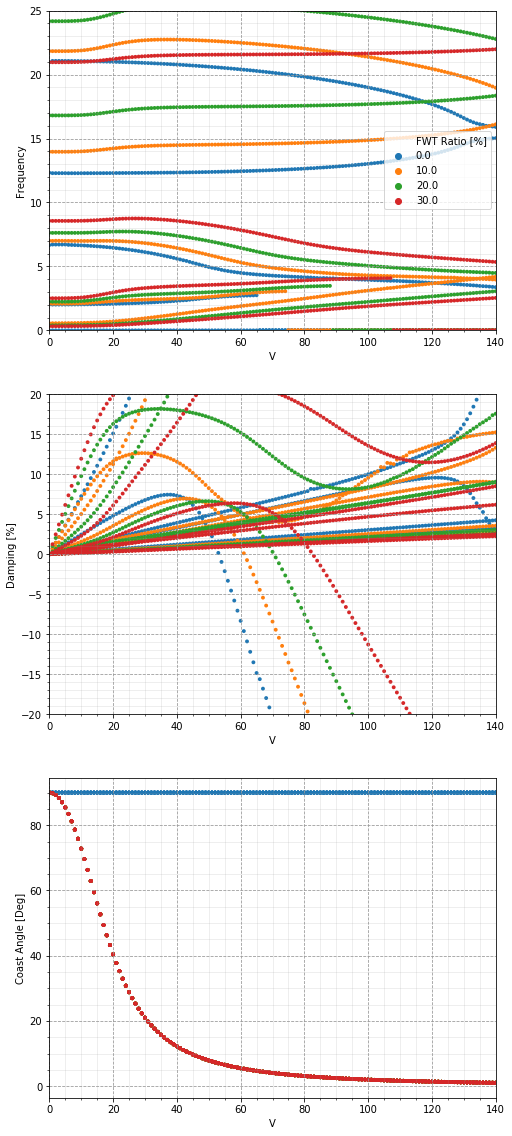

In [12]:
data = flutdf.copy()
data = data[data['Flare Angle [Deg]']==25]
data = data[data['AoA [Deg]']==0]
data = data[data['FWT Mass [%]']==100]
data = data[data['V']<=150]
fig, axes = plt.subplots(3,1,figsize=(8,20))


sns.scatterplot(data=data,x='V',y='Frequency',hue='FWT Ratio [%]',ax=axes[0],edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y='Damping [%]',hue='FWT Ratio [%]',ax=axes[1],legend=False,edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y='Coast Angle [Deg]',hue='FWT Ratio [%]',ax=axes[2],legend=False,edgecolor = 'none',s=15)

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,140))
#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,25))
axes[1].set(ylim=(-20,20))

In [13]:
flutdf.to_pickle(f'Test_{test_num}.pkl')

In [14]:
pd.read_pickle(f'Test_{test_num}.pkl').head()

,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,q,delta_m,Lambda,alpha_r,sigma,V,Damping [%],Coast Angle [Deg],Flare Angle [Deg],AoA [Deg],FWT Mass [%],FWT Ratio [%]
0,0.000000+0.000000j,0.0,0.000000,0.000000,NaN,True,"[0j, 0j, 0j, 0j, 0j, 0j, (1+0j), 0j, 0j, 0j, 0...",0,"[-6.854167596952895e-09, 0, -2.538812563836802...",0.5,0.174533,0.0,0.0,0.0,NaN,90.0,10.0,0.0,50.0,0.0
1,0.000000+12.694100j,0.0,12.694100,2.020329,6.123234e-17,True,"[0.06301112629773432j, -0.002902679604713628j,...",1,"[-6.854167596952895e-09, 0, -2.538812563836802...",0.5,0.174533,0.0,0.0,0.0,-6.123234e-15,90.0,10.0,0.0,50.0,0.0
2,0.000000+41.912597j,0.0,41.912597,6.670597,6.123234e-17,True,"[0.00021981442767313365j, 6.645942046166918e-0...",2,"[-6.854167596952895e-09, 0, -2.538812563836802...",0.5,0.174533,0.0,0.0,0.0,-6.123234e-15,90.0,10.0,0.0,50.0,0.0
3,0.000000+77.429442j,0.0,77.429442,12.323278,6.123234e-17,True,"[0.0049873634540200254j, -0.000785972551326961...",3,"[-6.854167596952895e-09, 0, -2.538812563836802...",0.5,0.174533,0.0,0.0,0.0,-6.123234e-15,90.0,10.0,0.0,50.0,0.0
4,0.000000+131.739306j,0.0,131.739306,20.966962,6.123234e-17,True,"[0.00040785744865968684j, -6.456588060225541e-...",4,"[-6.854167596952895e-09, 0, -2.538812563836802...",0.5,0.174533,0.0,0.0,0.0,-6.123234e-15,90.0,10.0,0.0,50.0,0.0
